In [1]:
from EBL_signal import * 

Note: redshifts have been re-sorted (earliest first)


In [4]:
def dJdz_this(z, detector, npoints, run = False,\
         vals_eps1500=False,vals_alpha1500=False,vals_alpha1100=False,val_EW=False,val_flyc=False,val_alpha900=False, filename = ''):

    if run:
        if detector == 'GALEX_NUV':
            nu_min = nu_min_gNUV
            nu_max = nu_max_gNUV

        elif detector == 'GALEX_FUV':
            nu_min = nu_min_gFUV
            nu_max = nu_max_gFUV

        elif detector == 'ULTRASAT':
            nu_min = nu_min_US
            nu_max = nu_max_US

        else:
            print('Check detector!')
            return 

        unit = (Response(lambda_from_nu(1.*u.Hz), detector) *signal(lambda_from_nu(1*u.Hz),0.,detector,vals_eps1500,vals_alpha1500,vals_alpha1100,val_EW,val_flyc,val_alpha900,to_plot=True) * np.exp(-tau_Lya(lambda_from_nu(1*u.Hz),0.))/(1*u.Hz)).unit

        intg = lambda nu_obs: Response(lambda_from_nu(nu_obs*u.Hz), detector) * signal(lambda_from_nu(nu_obs*u.Hz*(1+z)),z,detector,vals_eps1500,vals_alpha1500,vals_alpha1100,val_EW,val_flyc,val_alpha900,to_plot=True).value * np.exp(-tau_Lya(lambda_from_nu(nu_obs*u.Hz),z))/nu_obs 

        rest_wave = np.linspace(lambda_from_nu(nu_min).value,lambda_from_nu(nu_max).value,npoints)

        nu_obs_arr = np.zeros(len(rest_wave))
        intg_arr = np.zeros(len(rest_wave))
        for i in range(len(rest_wave)):
            nu_obs_arr[i] = nu_from_lambda(rest_wave[i]*u.AA).value
            intg_arr[i] = intg(nu_obs_arr[i])

        dJdz = cu.c.to(u.km/u.s) / (4*np.pi*H(z)*(1+z)) * np.trapz(intg_arr,nu_obs_arr)*(unit*u.Hz/u.steradian) 

    else:
        zval, dJdzval = np.genfromtxt(filename)
        dJdz = interp1d(zval,dJdzval)(z) * u.Jy/u.steradian  

    return (dJdz.to(u.Jy/u.steradian)).value


def bJ_z_this(z, detector, npoints, run = False, vals_eps1500=False,vals_alpha1500=False,vals_alpha1100=False,val_EW=False,val_flyc=False,val_alpha900=False,val_bias=False, filename = ''):

    if run:
        if detector == 'GALEX_NUV':
            nu_min = nu_min_gNUV
            nu_max = nu_max_gFUV

        elif detector == 'GALEX_FUV':
            nu_min = nu_min_gFUV
            nu_max = nu_max_gFUV

        elif detector == 'ULTRASAT':
            nu_min = nu_min_US
            nu_max = nu_max_US

        else:
            print('Check detector!')
            return 
#
        intg_num = lambda nu_obs: bias(nu_obs*u.Hz*(1+z),z,val_bias) * Response(lambda_from_nu(nu_obs*u.Hz), detector) * signal(lambda_from_nu(nu_obs*u.Hz*(1+z)),z,detector,vals_eps1500,vals_alpha1500,vals_alpha1100,val_EW,val_flyc,val_alpha900,to_plot=True).value * np.exp(-tau_Lya(lambda_from_nu(nu_obs*u.Hz),z))/nu_obs 
#
        intg_den = lambda nu_obs: Response(lambda_from_nu(nu_obs*u.Hz), detector) * signal(lambda_from_nu(nu_obs*u.Hz*(1+z)),z,detector,vals_eps1500,vals_alpha1500,vals_alpha1100,val_EW,val_flyc,val_alpha900,to_plot=True).value * np.exp(-tau_Lya(lambda_from_nu(nu_obs*u.Hz),z))/nu_obs 

        rest_wave = np.linspace(lambda_from_nu(nu_min).value,lambda_from_nu(nu_max).value,npoints)

        nu_obs_arr = np.zeros(len(rest_wave))
        intg_arr = np.zeros(len(rest_wave))
        intg_den_arr = np.zeros(len(rest_wave))
        for i in range(len(rest_wave)):
            nu_obs_arr[i] = nu_from_lambda(rest_wave[i]*u.AA).value
            intg_arr[i] = intg_num(nu_obs_arr[i])
            intg_den_arr[i] = intg_den(nu_obs_arr[i])

        # num = quad(intg_num,nu_min.value,nu_max.value)[0]
        # den = quad(intg_den,nu_min.value,nu_max.value)[0]
        num = np.trapz(intg_arr,nu_obs_arr)
        den = np.trapz(intg_den_arr,nu_obs_arr)

        bJ = num / den

    else:
        zval, bJval = np.genfromtxt(filename)
        bJ = interp1d(zval,bJval)(z) 

    return bJ

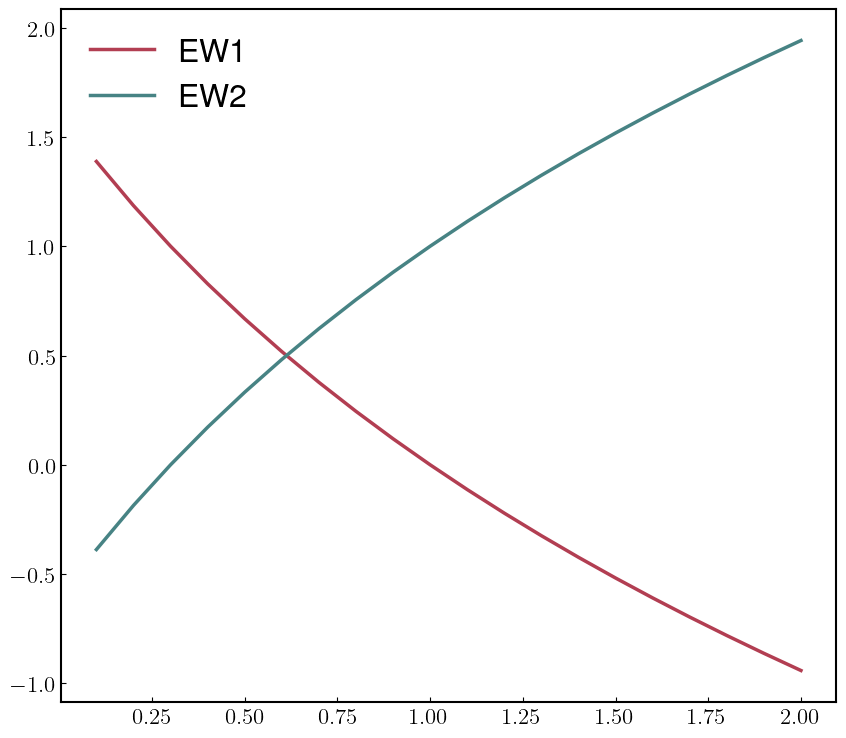

In [6]:
z1 = 0.3
z2 = 1.

d2 = lambda z: np.log10((1+z)/(1+z1)) / np.log10((1+z2)/(1+z1))
d1 = lambda z: 1-np.log10((1+z)/(1+z1)) / np.log10((1+z2)/(1+z1))


plt.plot(z_gals_interp,d1(z_gals_interp),label='EW1')
plt.plot(z_gals_interp,d2(z_gals_interp),label='EW2')

plt.legend()

In [7]:
npt = [1000]

for i in tqdm(npt):
    with Pool(6) as pool:
        dJdz_NUV = partial(dJdz_this,detector='ULTRASAT',npoints=i,run=True, filename=use_results_dir + 'EBL/dJdz_npt'+str(i) + '_GALEX_NUV_reduced.dat')
        dJ_nuv = np.asarray(pool.map(dJdz_NUV, z_gals_interp))

        # bJ_NUV = partial(bJ_z_this,detector='ULTRASAT',npoints=i,run=True, filename=use_results_dir + 'EBL/bJ_npt' + str(i) + '_ULTRASAT_reduced.dat')
        # bJ_nuv = np.asarray(pool.map(bJ_NUV, z_gals_interp))

    plt.plot(z_gals_interp,dJ_nuv,label=r'$npt = %g$'%i)
    # plt.plot(z_gals_interp,bJ_nuv,label=r'$npt = %g$'%i)
   # plt.plot(z_gals_interp,bJ_nuv*dJ_nuv,label=r'$npt = %g$'%i)


with Pool(6) as pool:
    dJdz_NUV = partial(dJdz,detector='ULTRASAT',run=False, filename= 'results/EBL/dJdz_ULTRASAT_reduced.dat')
    dJ_nuv = np.asarray(pool.map(dJdz_NUV, z_gals_interp))

    # bJ_NUV = partial(bJ_z,detector='ULTRASAT',run=False, filename= 'results/EBL/bJ_ULTRASAT_reduced.dat')
    # bJ_nuv = np.asarray(pool.map(bJ_NUV, z_gals_interp))

plt.plot(z_gals_interp,dJ_nuv,'k:',label=r'$In\,paper$')
# plt.plot(z_gals_interp,bJ_nuv,'k',label=r'$In\,paper$')
#plt.plot(z_gals_interp,bJ_nuv*dJ_nuv,'k',label=r'$In\,paper$')

with Pool(6) as pool:
    dJdz_NUV = partial(dJdz,detector='ULTRASAT',run=False, filename= use_results_dir + 'EBL/dJdz_ULTRASAT_reduced.dat')
    dJ_nuv = np.asarray(pool.map(dJdz_NUV, z_gals_interp))

    # bJ_NUV = partial(bJ_z,detector='ULTRASAT',run=False, filename=use_results_dir + 'EBL/bJ_ULTRASAT_reduced.dat')
    # bJ_nuv = np.asarray(pool.map(bJ_NUV, z_gals_interp))

plt.plot(z_gals_interp,dJ_nuv,'k--',label=r'$Weird$')
# plt.plot(z_gals_interp,bJ_nuv,'k--',label=r'$Weird$')
#plt.plot(z_gals_interp,bJ_nuv*dJ_nuv,'k--',label=r'$Weird$')

plt.legend()

plt.show()

  0%|          | 0/1 [00:07<?, ?it/s]


KeyboardInterrupt: 